# Livrable 2 - Denoising d'images

|Auteurs|
|---|
|Frédéric SPATARO|
|Oscar PALISSOT|
|Djayan DEMAISON|
|Arnaud HITTINGER|
|Nicolas PELLEGRINI|

# 1. Introduction

## 1.1. Présentation du problème de débruitage d'image

Le débruitage d'images, ou denoising, est une étape cruciale dans le prétraitement des données, en particulier dans le contexte des données numérisées. Les images numérisées, en particulier celles qui proviennent de documents papier, peuvent présenter divers degrés de bruit sous forme de points, de stries ou d'autres artefacts visuels qui peuvent potentiellement interférer avec les analyses ultérieures, telles que la classification ou la génération de légendes. Le débruitage est donc essentiel pour assurer la précision et la fiabilité des modèles de machine learning qui seront appliqués par la suite.

## 1.2. Objectifs du Notebook

L'objectif de ce notebook est de mettre en œuvre une solution de débruitage d'images en utilisant des auto-encodeurs convolutifs. Nous chercherons à :

- Préparer les données d'images pour l'entraînement du modèle.
- Construire et entraîner un auto-encodeur convolutif pour le débruitage d'images.
- Évaluer les performances du modèle et visualiser les résultats.
- Fournir une analyse critique des résultats et identifier les domaines potentiels d'amélioration.

## 1.3. Briève introduction aux auto-encodeurs

Les auto-encodeurs sont un type de réseau de neurones utilisé pour l'apprentissage non supervisé. Ils visent à apprendre une représentation (encodage) efficace des données, généralement dans le but de réduire la dimensionnalité. Un auto-encodeur est structuré en deux parties principales :

- Encodeur: Il apprend à compresser l'entrée dans une forme latente, souvent de dimensionnalité réduite.
- Décodeur: Il apprend à reconstruire l'entrée à partir de cette forme latente.

Dans le contexte du débruitage d'images, les auto-encodeurs sont entraînés pour mapper des images bruitées à leurs versions propres, en apprenant à supprimer le bruit tout en conservant les caractéristiques importantes des données.

# 2. Importation et exploration des données

## 2.1. Importation des bibliothèques nécessaires

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

print("Import terminé.")

Import terminé.


## 2.2. Chargement du dataset d'images

In [2]:
data_dir = 'DataL2'
image_files = os.listdir(data_dir)

# Charger les images dans une liste et les convertir en tableau numpy pour faciliter la manipulation ultérieure
images = []
for img_file in image_files:
    img_path = os.path.join(data_dir, img_file)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images)

print("Chargement terminé.")

Chargement terminé.


## 2.3. Exploration des données

In [3]:
# Afficher quelques informations de base sur les données
print(f"Nombre total d'images : {images.shape[0]}")
print(f"Dimensions des images : {images.shape[1:]}")
print(f"Valeur min des pixels : {np.min(images)}")
print(f"Valeur max des pixels : {np.max(images)}")

print("\nExploration terminé.")

Nombre total d'images : 148
Dimensions des images : (128, 128, 3)
Valeur min des pixels : 0.0
Valeur max des pixels : 255.0

Exploration terminé.


## 2.4. Visualisation d'exemples d'images

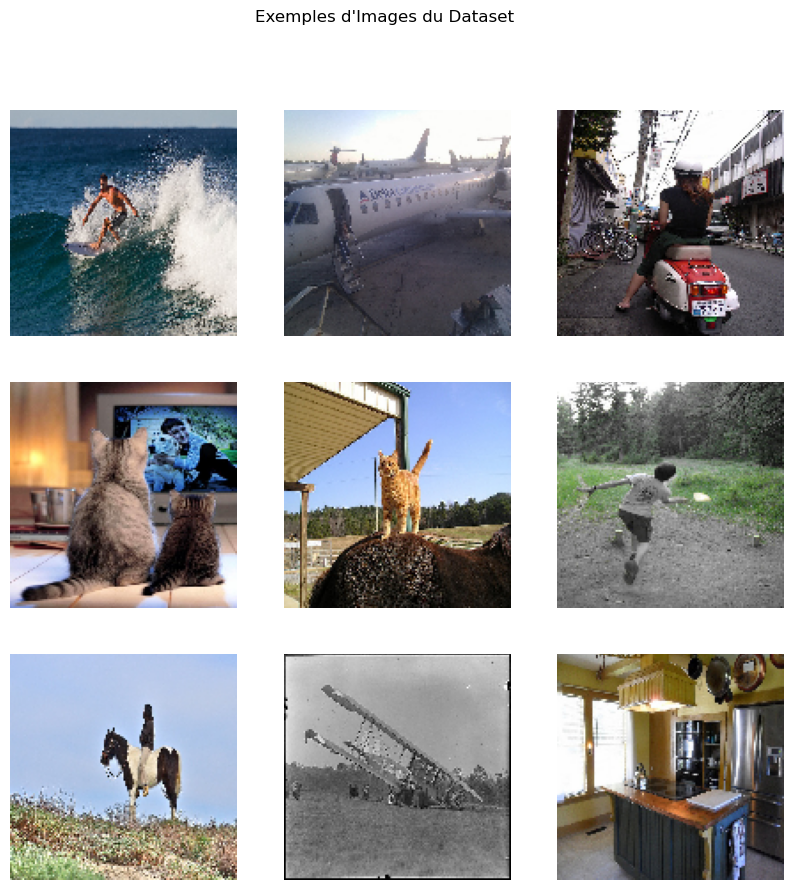

Visualisation terminé.


In [4]:
# Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
plt.suptitle('Exemples d\'Images du Dataset')
plt.show()

print("Visualisation terminé.")

## 2.5. Distribution des valeurs de pixel

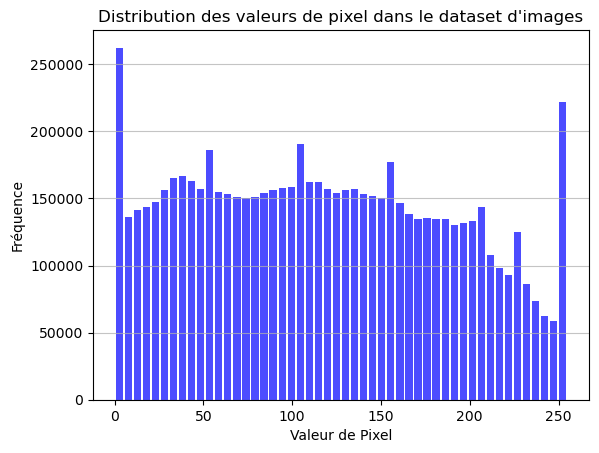

La valeur moyenne des pixels est: 117.63
L'écart-type des valeurs de pixel est: 71.57
Visualisation terminé.


In [5]:
# Calculer la distribution des valeurs de pixel
pixel_values = images.flatten()
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7, rwidth=0.8)
plt.title('Distribution des valeurs de pixel dans le dataset d\'images')
plt.xlabel('Valeur de Pixel')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calculer et afficher la moyenne et l'écart-type des valeurs de pixel
mean_pixel_value = np.mean(pixel_values)
std_pixel_value = np.std(pixel_values)
print(f"La valeur moyenne des pixels est: {mean_pixel_value:.2f}")
print(f"L'écart-type des valeurs de pixel est: {std_pixel_value:.2f}")

print("Visualisation terminé.")

# 3. Préparation des données

## 3.1. Normalisation des images

In [6]:
# Normaliser les images pour que les valeurs de pixel soient dans [0, 1]
normalized_images = images / 255.0

print("Normalisation terminé.")

Normalisation terminé.


## 3.2. Bruitage artificiel des images

In [7]:
# Paramètres pour l'ajout de bruit
noise_factor = 0.15

# Ajout de bruit gaussien aux images
noisy_images = normalized_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images = np.clip(noisy_images, 0., 1.)

print("Bruitage terminé.")

Bruitage terminé.


## 3.3. Division en série d'entraînement et de test

In [8]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    noisy_images,  # les images bruitées -> entrées
    normalized_images,  # les images originales -> cibles
    test_size=0.2,
    random_state=42
)

print("Division en test/train terminé.")

Division en test/train terminé.


## 3.4. Visualisation des images bruitées

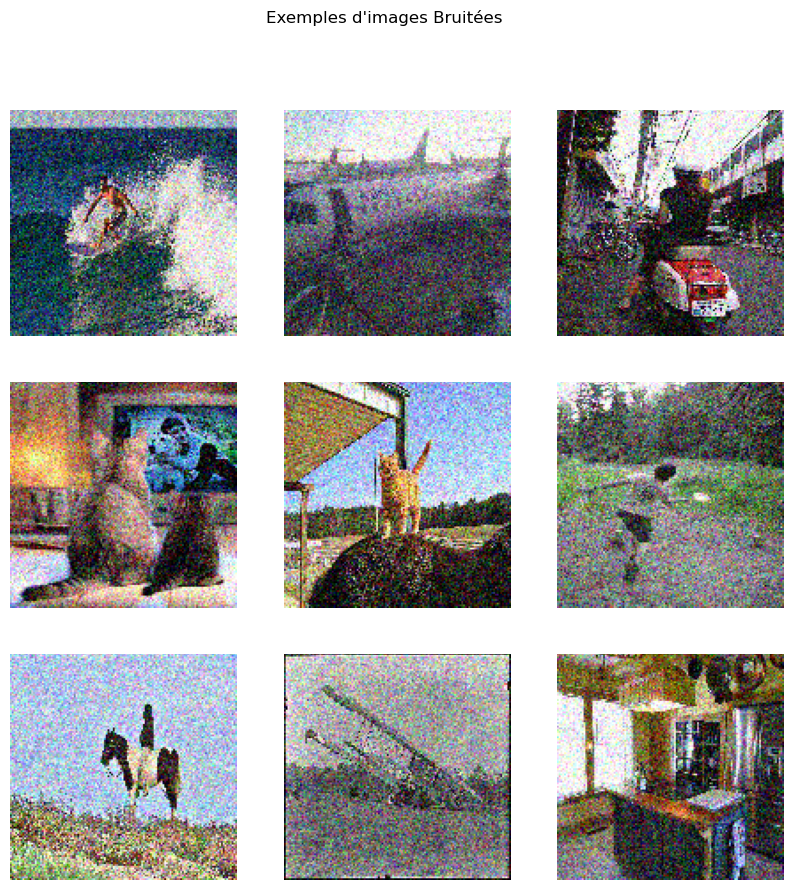

Visualisation terminé.


In [9]:
# Afficher quelques images bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images Bruitées')
plt.show()

print("Visualisation terminé.")

# 4. Construction de l'auto-encodeur convolutif

## 4.1. Architecture de l'encodeur

In [10]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(128, 128, 3))

# Encodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

print("Encodage terminé.")

Encodage terminé.


## 4.2. Architecture du décodeur

In [11]:
# Décodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

print("Décodage terminé.")

Décodage terminé.


## 4.3. Modèle d'auto-encodeur complet

In [12]:
# Modèle
autoencoder = Model(input_img, decoded)

print("Modèle terminé.")

Modèle terminé.


## 4.4. Compilation du modèle de l'auto-encodeur

In [13]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print("Compilation terminée.")

Compilation terminée.


# 5. Entraînement du modèle

## 5.1. Définition des hyperparamètres

In [14]:
epochs = 250
batch_size = 128

print("Hyperparamètres définis.")

Hyperparamètres définis.


## 5.2. Entraînement de l'auto-encodeur

In [15]:
history = autoencoder.fit(
    X_train,  # images bruitées
    y_train,  # images originales
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test, y_test),
)

print("Auto-encodeur entraîné.")

Epoch 1/250
1/1 [==============================] - 5s 5s/step - loss: 0.6934 - val_loss: 0.6912
Epoch 2/250
1/1 [==============================] - 3s 3s/step - loss: 0.6900 - val_loss: 0.6891
Epoch 3/250
1/1 [==============================] - 4s 4s/step - loss: 0.6870 - val_loss: 0.6863
Epoch 4/250
1/1 [==============================] - 3s 3s/step - loss: 0.6829 - val_loss: 0.6827
Epoch 5/250
1/1 [==============================] - 3s 3s/step - loss: 0.6780 - val_loss: 0.6773
Epoch 6/250
1/1 [==============================] - 3s 3s/step - loss: 0.6718 - val_loss: 0.6703
Epoch 7/250
1/1 [==============================] - 3s 3s/step - loss: 0.6640 - val_loss: 0.6606
Epoch 8/250
1/1 [==============================] - 3s 3s/step - loss: 0.6535 - val_loss: 0.6480
Epoch 9/250
1/1 [==============================] - 3s 3s/step - loss: 0.6403 - val_loss: 0.6335
Epoch 10/250
1/1 [==============================] - 3s 3s/step - loss: 0.6249 - val_loss: 0.6195
Epoch 11/250
1/1 [=====================

1/1 [==============================] - 3s 3s/step - loss: 0.5448 - val_loss: 0.5549
Epoch 86/250
1/1 [==============================] - 3s 3s/step - loss: 0.5447 - val_loss: 0.5552
Epoch 87/250
1/1 [==============================] - 3s 3s/step - loss: 0.5446 - val_loss: 0.5547
Epoch 88/250
1/1 [==============================] - 3s 3s/step - loss: 0.5446 - val_loss: 0.5551
Epoch 89/250
1/1 [==============================] - 3s 3s/step - loss: 0.5444 - val_loss: 0.5545
Epoch 90/250
1/1 [==============================] - 3s 3s/step - loss: 0.5442 - val_loss: 0.5544
Epoch 91/250
1/1 [==============================] - 3s 3s/step - loss: 0.5441 - val_loss: 0.5546
Epoch 92/250
1/1 [==============================] - 3s 3s/step - loss: 0.5440 - val_loss: 0.5541
Epoch 93/250
1/1 [==============================] - 3s 3s/step - loss: 0.5440 - val_loss: 0.5544
Epoch 94/250
1/1 [==============================] - 3s 3s/step - loss: 0.5438 - val_loss: 0.5539
Epoch 95/250
1/1 [=========================

Epoch 169/250
1/1 [==============================] - 3s 3s/step - loss: 0.5396 - val_loss: 0.5488
Epoch 170/250
1/1 [==============================] - 3s 3s/step - loss: 0.5393 - val_loss: 0.5500
Epoch 171/250
1/1 [==============================] - 3s 3s/step - loss: 0.5399 - val_loss: 0.5487
Epoch 172/250
1/1 [==============================] - 3s 3s/step - loss: 0.5393 - val_loss: 0.5486
Epoch 173/250
1/1 [==============================] - 3s 3s/step - loss: 0.5392 - val_loss: 0.5497
Epoch 174/250
1/1 [==============================] - 3s 3s/step - loss: 0.5396 - val_loss: 0.5486
Epoch 175/250
1/1 [==============================] - 3s 3s/step - loss: 0.5391 - val_loss: 0.5485
Epoch 176/250
1/1 [==============================] - 3s 3s/step - loss: 0.5390 - val_loss: 0.5493
Epoch 177/250
1/1 [==============================] - 3s 3s/step - loss: 0.5393 - val_loss: 0.5484
Epoch 178/250
1/1 [==============================] - 3s 3s/step - loss: 0.5390 - val_loss: 0.5483
Epoch 179/250
1/1 [=

## 5.3. Visualisation de la loss durant l'entraînement

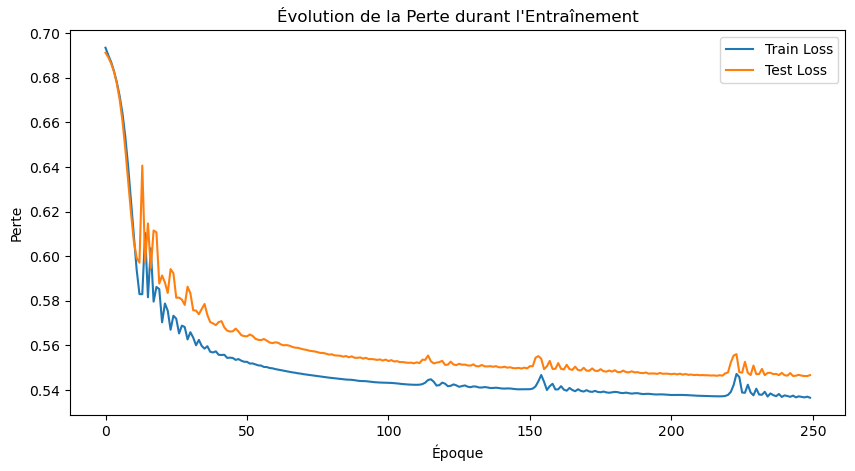

Loss visualisé.


In [16]:
# Tracer l'historique de la perte durant l'entraînement
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Évolution de la Perte durant l\'Entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.show()

print("Loss visualisé.")

# 6. Évaluation du modèle

## 6.1. Évaluation quantitative du modèle sur l'ensemble de test

In [17]:
evaluation = autoencoder.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test loss (lower is better): {evaluation:.4f}")

1/1 [==============================] - 0s 144ms/step - loss: 0.5467
Test loss (lower is better): 0.5467


## 6.2. Visualisation des images débruitées

1/1 [==============================] - 0s 206ms/step


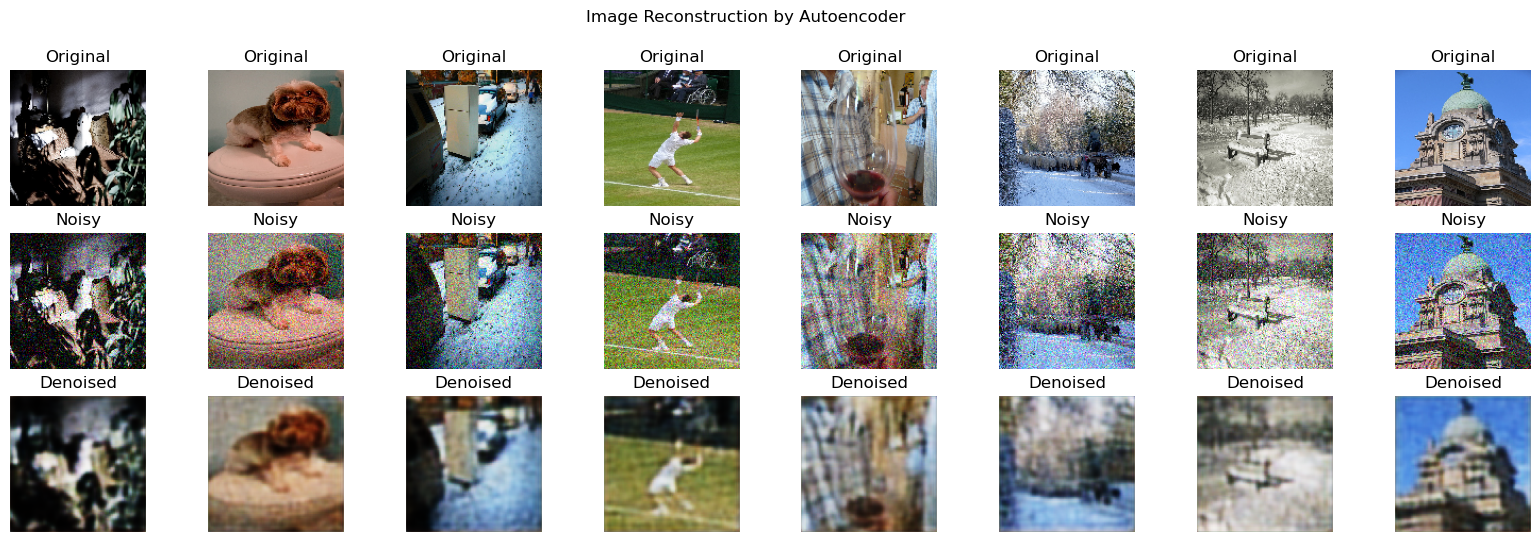

In [18]:
# Prédiction des images débruitées à partir des images bruitées
decoded_imgs = autoencoder.predict(X_test)

# Affichage des images originales, bruitées et débruitées
plt.figure(figsize=(20, 6))

num_images_to_show = 8  # ajuster selon vos besoins

for i in range(num_images_to_show):
    # Images originales
    ax = plt.subplot(3, num_images_to_show, i + 1)
    plt.imshow(y_test[i].reshape(128, 128, 3))
    plt.title("Original")
    plt.axis("off")
    
    # Images bruitées
    ax = plt.subplot(3, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(X_test[i].reshape(128, 128, 3))
    plt.title("Noisy")
    plt.axis("off")
    
    # Images débruitées générées par l'auto-encodeur
    ax = plt.subplot(3, num_images_to_show, i + 1 + 2*num_images_to_show)
    plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
    plt.title("Denoised")
    plt.axis("off")

plt.suptitle("Image Reconstruction by Autoencoder")
plt.show()

## 6.3. Comparaison des Images originales, bruitées et débruitées

Pour effectuer une analyse plus détaillée, vous pourriez comparer les distributions de pixel des images originales et débruitées, calculer des métriques d'image (par exemple, PSNR, SSIM), etc. Mais cette section peut varier en fonction de vos besoins spécifiques.

Notez que pour la visualisation des images, vous devrez ajuster les dimensions pour correspondre à la taille réelle de vos images. En outre, selon vos données, vous devrez peut-être ajuster la manière dont les images sont normalisées avant d'être visualisées.

Si vous avez besoin d'ajuster quelque chose ou si vous avez des questions, n'hésitez pas à le faire savoir !